# ALGONQUIN
This notebook implements the ALGONQUIN algorithm from literature.

## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter
using BenchmarkTools

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


## Set parameters

In [2]:
# signal preprocessing
sound_file1 = "../data/woman.wav"     # specify sound location
sound_file2 = "../data/leaves.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 40                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 4                         # specify desired stepsize (currently trade-off between step size and distortion) TODO: ask Tanya, Bert or Joris
;

In [3]:
function ALGONQUIN(μs::Array{Float64,1}, Σs::Diagonal{Float64,Array{Float64,1}}, g, gprime, Ψ::Diagonal{Float64,Array{Float64,1}}, y::Array{Float64,1}, πs::Float64, iterations::Int64=5)::Tuple{Array{Float64,1},Float64} 
    # set initial parameters
    ηs = μs
    Φs = Matrix(Σs)

    # calculate inverses to save time
    iΨ = inv(Ψ)
    iΣ = inv(Σs)
    
    # iterative laplace
    @inbounds for _ = 1:iterations
        
        gprime_ηs = gprime(ηs)

        # update Φs
        Φs = inv(Matrix(iΣ + gprime_ηs'*iΨ*gprime_ηs))

        # update ηs
        ηs = ηs + Φs * (iΣ*(μs - ηs) + gprime_ηs'*iΨ*(y-g(ηs)))

    end

    gprime_ηs = gprime(ηs)
    y_g_ηs = y - g(ηs)
    ηs_μs = ηs - μs
    
    # update responsibilties (leave out λ for later normalization and apply trick of https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
    ρs = log(πs) -
         1/2*log(2*pi*det(Σs)) +
         1/2*log(2*pi*det(Φs)) -
         1/2*(y_g_ηs)'*iΨ*(y_g_ηs) -
         1/2*tr(iΣ*Φs) -
         1/2*(ηs_μs)'*iΣ*(ηs_μs) -
         1/2*tr(gprime_ηs'*iΨ*gprime_ηs*Φs)
    
    # return posterior beliefs
    return ηs, ρs
end
;

## Create functions for algorithm

In [4]:
function ALGONQUIN_frame(g_speech, g_noise, data::Array{Float64,1})::Array{Float64,1}
    
    # get nr clusters
    Ns = g_speech.n
    Nn = g_noise.n

    # create array for algorithm output
    η = Array{Array{Float64,1},1}(undef, Ns*Nn)
    ρ = Vector{Float64}(undef, Ns*Nn)

    # get value of M 
    M = length(data)
    d = ones(M)
    d1 = 1*Diagonal(d)

    # loop through different mixture models
    @inbounds for s = 1:Ns*Nn

        # set indices
        ni = ((s-1) % Nn) + 1
        si = Int(ceil(s/Nn))

        # calculate prior responsibilities
        πs = weights(g_speech)[si] * weights(g_noise)[ni]
        
        # set prior variables
        μs = vcat(means(g_speech)[si,:], means(g_noise)[ni,:], zeros(M))
        Σs = Diagonal(vcat(g_speech.Σ[si,:], g_noise.Σ[ni,:], 1e-10*d))
        
        # perform ALGONQUIN algorithm
        η[s], ρ[s] = ALGONQUIN(μs, Σs, logsumexp, J_logsumexp, d1, data, πs, 5)
        
    end
    
    # normalize ρ with trick to prevent underflow
    ρ = ρ .- maximum(ρ)
    ρ = exp.(ρ)./sum(exp.(ρ))
    
    # calculate estimate of speech and noise signals
    return sum(ρ.*η)
    
end;

In [5]:
function trainGMM(clusters::Int64, y::Array{Float64,2}, kind::Symbol)
    if (kind == :full) & isposdef(y)
        g = GMM(clusters, y, kind=kind)
        p = GMMprior(g.d, 0.1, 1.0)  ## set α0=0.1 and β0=1, and other values to a default
        v = VGMM(g, p) ## initialize variational GMM v with g
        em!(v, y)
    elseif (kind == :full) & ~isposdef(y)
        println("data matrix not posdef, going for diagonal GMM")
        g = GMM(clusters, y, kind=:diag)
        em!(g, y)
    else
        g = GMM(clusters, y, nIter=50, nInit=100, kind=:diag)
        em!(g, y)
    end
    return g
end;

In [6]:
function preprocess(x::Array{Float64,1}, fs::Int64; fs_desired::Int64=8000, normalization_method::String="max")
    y = resample(x, fs_desired/fs)
    y = normalize(y, normalization_method)
    return y
end;

In [7]:
function logsumexp(y::Array{Float64,1})
    # fetch length of single segment
    M = Int(length(y)/3)
    
    # get x, h n
    x = y[0*M+1:1*M]
    n = y[1*M+1:2*M]    
    h = y[2*M+1:3*M]
    
    return h + x + log.(1 .+ exp.(n-h-x))
end;

In [8]:
function J_x_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(1 .- exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_n_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_h_logsumexp(x::Array{Float64,1}, n::Array{Float64,1}, h::Array{Float64,1})
    return Diagonal(1 .- exp.(n - h - x)./(1 .+ exp.(n - h - x)))
end

function J_logsumexp(y::Array{Float64,1})
    # fetch length of single segment
    M = Int(length(y)/3)
    
    # get x, h n
    x = y[0*M+1:1*M]
    n = y[1*M+1:2*M]    
    h = y[2*M+1:3*M]

    
    return hcat(J_x_logsumexp(x,n,h), J_n_logsumexp(x,n,h), J_h_logsumexp(x,n,h))
end;

## Load and process signals

In [9]:
# load speech data
x_speech, fs_speech = wavread(sound_file1, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:4*fs_speech]

# load noise data
x_noise, fs_noise = wavread(sound_file2, format="native")
fs_noise = Int(fs_noise)
x_noise = convert(Array{Float64,1}, squeeze(x_noise[:,1]))[1*fs_noise:4*fs_noise]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)
y_noise = preprocess(x_noise, fs_noise)
y_tot = y_noise + y_speech

# warp signal and take fft
f_speech = warp_fft(y_speech, pole_location, nr_freqs, step_size=step_size)
f_noise = warp_fft(y_noise, pole_location, nr_freqs, step_size=step_size)
f_tot = warp_fft(y_tot, pole_location, nr_freqs, step_size=step_size)

# get the log abs values
z_speech = log.(abs2.(f_speech))[:,1:Int(nr_freqs/2+1)]
z_noise = log.(abs2.(f_noise))[:,1:Int(nr_freqs/2+1)]
z_tot = log.(abs2.(f_tot))[:,1:Int(nr_freqs/2+1)]

# create audioplayers for signals
audioplayers(y_speech, y_noise, y_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

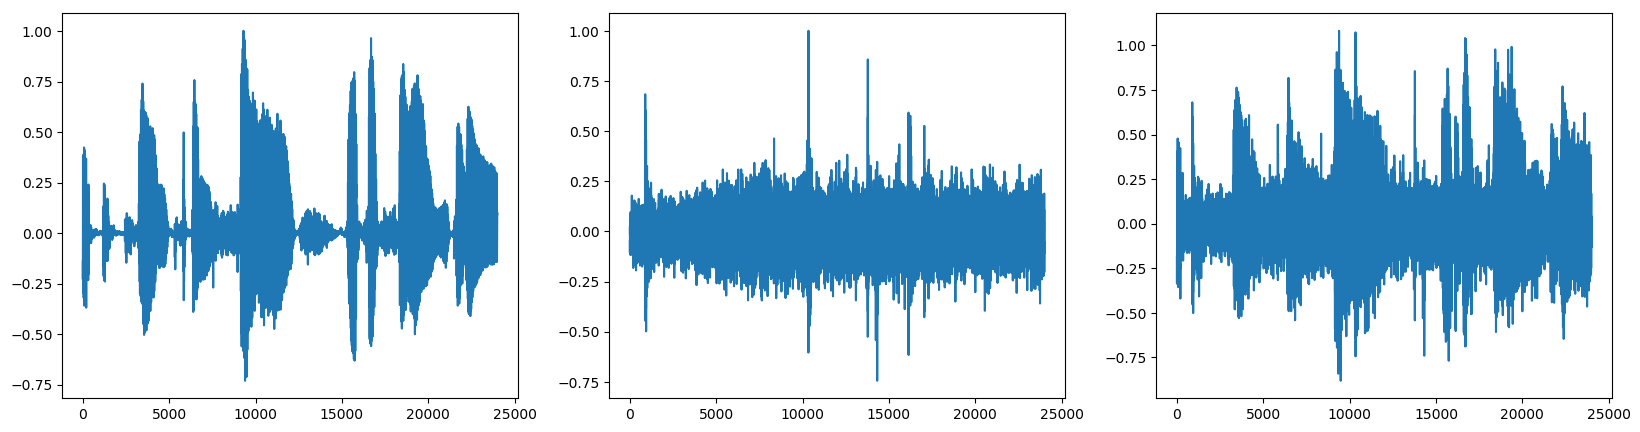

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006315E0F0>

In [10]:
_, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[1].plot(y_speech)
ax[2].plot(y_noise)
ax[3].plot(y_tot)

## Train GMM on data

In [11]:
# train GMMs 
Ns = 10
Nn = 2
g_speech = trainGMM(Ns, z_speech, :diag)
g_noise = trainGMM(Nn, z_noise, :diag)
println(avll(g_speech, z_speech))
;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.956292e+05
      1       3.000000e+05      -1.956292e+05 |       10
      2       2.894278e+05      -1.057218e+04 |       10
      3       2.873737e+05      -2.054124e+03 |       10
      4       2.864990e+05      -8.746279e+02 |       10
      5       2.858279e+05      -6.711798e+02 |       10
      6       2.851909e+05      -6.369197e+02 |       10
      7       2.845330e+05      -6.579090e+02 |       10
      8       2.837635e+05      -7.695272e+02 |     

┌ Info: Initializing GMM, 10 Gaussians diag covariance 21 dimensions using 5990 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78


  10
      9       2.828535e+05      -9.100160e+02 |       10
     10       2.815686e+05      -1.284903e+03 |       10
     11       2.805332e+05      -1.035354e+03 |       10
     12       2.795885e+05      -9.447210e+02 |       10
     13       2.787728e+05      -8.157301e+02 |       10
     14       2.781422e+05      -6.305388e+02 |        9
     15       2.774736e+05      -6.686707e+02 |        9
     16       2.769550e+05      -5.185904e+02 |       10
     17       2.765600e+05      -3.949421e+02 |       10
     18       2.762541e+05      -3.059817e+02 |       10
     19       2.760138e+05      -2.402947e+02 |        9
     20       2.758636e+05      -1.501747e+02 |       10
     21       2.757326e+05      -1.310260e+02 |       10
     22       2.756390e+05      -9.357466e+01 |        8
     23       2.755804e+05      -5.860272e+01 |       10
     24       2.755362e+05      -4.413804e+01 |        9
     25       2.755106e+05      -2.564376e+01 |        7
     26       2.754959e+05

┌ Info: K-means with 5990 data points using 44 iterations
│ 27.2 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.381850e+05
      1       8.883042e+04      -4.935457e+04 |        2
      2       8.581932e+04      -3.011096e+03 |        2
      3       8.488059e+04      -9.387285e+02 |        2
      4       8.461433e+04      -2.662628e+02 |        2
      5       8.444569e+04      -1.686399e+02 |        2
      6       8.437907e+04      -6.662038e+01 |        2
      7       8.432500e+04      -5.407084e+01 |        2
      8       8.426269e+04      -6.231392e+01 |        2
      9       8.420178e+04      -6.090939e+01 |        2
     10       8.416302e+04      -3.875241e+01 |        2
     11       8.414152e+04      -2.150195e+01 |        2
     12       8.412615e+04      -1.537353e+01 |        2
     13       8.411457e+04      -1.158274e+01 |        2
     14       8.410758e+04      -6.986665e+00 |        2
     15       8.410187e+04      -5.709973e+00 |        

┌ Info: Initializing GMM, 2 Gaussians diag covariance 21 dimensions using 5990 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78


K-means converged with 25 iterations (objv = 84090.62286733266)


┌ Info: K-means with 2000 data points using 25 iterations
│ 45.5 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


-1.8549008919428713


## Perform ALGONQUIN

In [12]:
# create output array
z_pred = Array{Float64, 2}(undef, size(z_tot,1), 3*size(z_tot,2))

# loop through frames
@showprogress "Processing..." for k = 1:size(z_tot,1)

    z_pred[k,:] = ALGONQUIN_frame(g_speech, g_noise, z_tot[k,:])
    
end

Processing...100%|██████████████████████████████████████| Time: 0:17:57


In [13]:
z_speech_pred = z_pred[:,1:Int(floor(size(z_pred,2)/3))]
z_speech_pred = hcat(z_speech_pred, reverse(z_speech_pred[:,2:end-1], dims=2))
z_noise_pred = z_pred[:,Int(floor(size(z_pred,2)/3))+1:2*Int(floor(size(z_pred,2)/3))]
z_noise_pred = hcat(z_noise_pred, reverse(z_noise_pred[:,2:end-1], dims=2))
;

## Plot results with correct phase

In [14]:
speech_pred = warp_ifft(sqrt.(exp.(z_speech_pred)).*exp.(1im*angle.(f_speech)), pole_location, step_size)
noise_pred = warp_ifft(sqrt.(exp.(z_noise_pred)).*exp.(1im*angle.(f_noise)), pole_location, step_size)
;

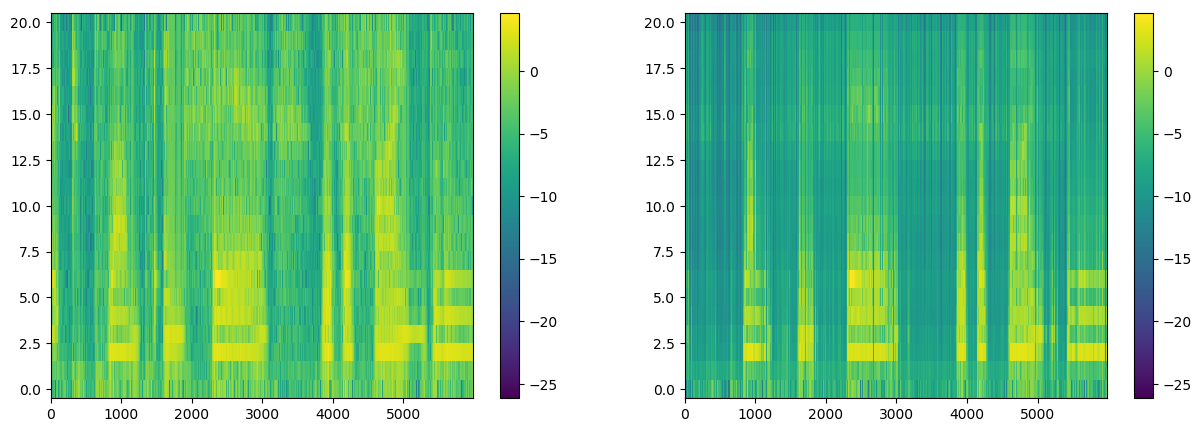

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
pcm = ax[1].imshow(z_speech', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[1])
ax[2].imshow(z_speech_pred[:,1:Int(nr_freqs/2+1)]', aspect="auto", origin="lower")
fig.colorbar(pcm, ax=ax[2])
;

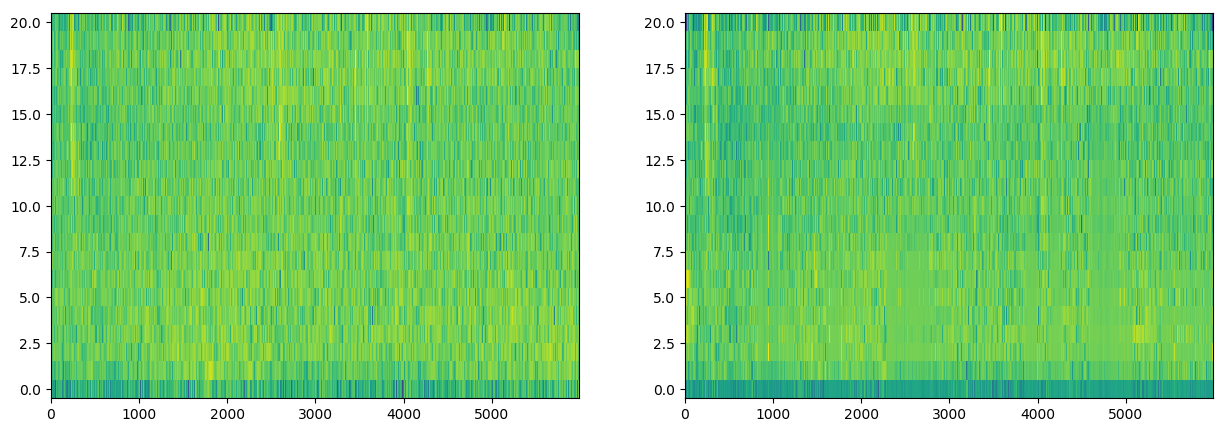

PyObject <matplotlib.image.AxesImage object at 0x000000006408DF28>

In [16]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(z_noise', aspect="auto", origin="lower")
ax[2].imshow(z_noise_pred[:,1:Int(nr_freqs/2+1)]', aspect="auto", origin="lower")

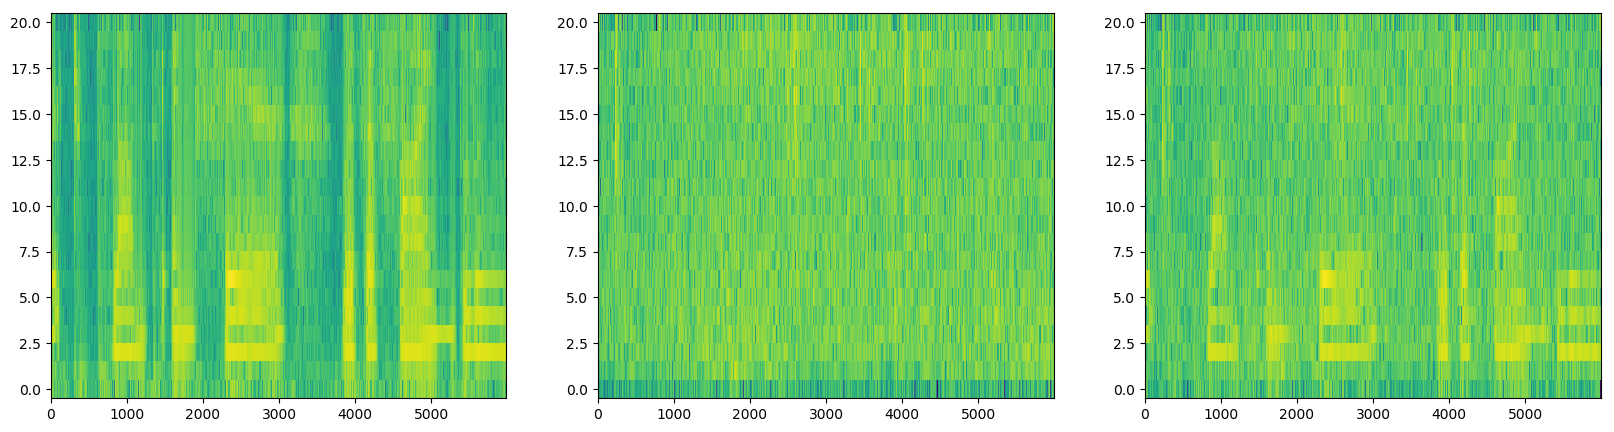

In [17]:
_, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[1].imshow(z_speech', aspect="auto", origin="lower")
ax[2].imshow(z_noise', aspect="auto", origin="lower")
ax[3].imshow(z_tot', aspect="auto", origin="lower")
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

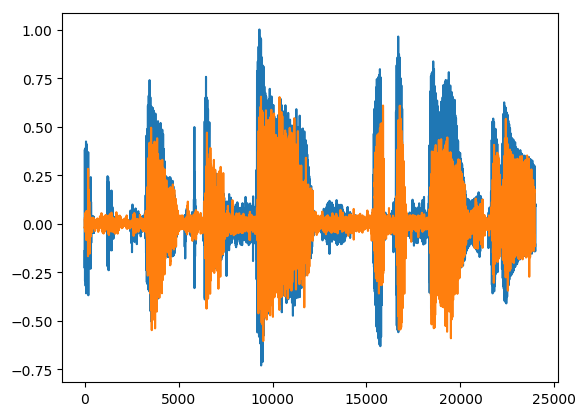

In [18]:
plt.plot(y_speech)
plt.plot(speech_pred)
audioplayers(y_speech, speech_pred, y_tot, fs=fs_desired)

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQDK80G94H7ZvTg4mb01RXC9sSnKPDokebzHbAO8i29PPZ65hz2IW5m66eC1PKIiz70AB4m9pjJTvWuxwLttCTk9v1WhPTkpdT1FlK08dg8pvTRoMz0dWJw9d3qiPQgQWT1tSL48SvssvQHwPLwAwSO84dBPuyay5jwyE/Q7rJOdPQEsIztWYby8uJ24vX9mZ72fhvG9Z3Xevc+Jwr2dvMO90uiiPG59G7yuFP88CJ26PRInHD3WdGg9fNxXPVUxtTx6f8c9qWwLPXSDajxAtXO7+VitvKNcFztdQ+E7C0mCuprfMLxr7Xo9lyoxOyQ7RzxiKZq78yxLu09hlTtiTCA9C4c6PZbEXr3E8A+8g02rO6jigzxxdpY7ha5bPdDeB7zYFQK8b6Ukvbu4pby2fL68DXdjPTT5ujwDk8A96LIwvUOqOjsU4G+9Rtzrvf3eYr18xBC7VxuWvUFFaL1ksAC8/ISOPVRICj08jV08KUULvWnktL2de5m9UhS/vcS5zrw4emi9VARuu0dbqr1ylzK80tPfuwECOz3NP6A9eIOUvBukNz1gezI9lGHfPJHD0byEzvS6NQ4nveeqbj2Yq9M8aTpYPH9kNj60yM28CVaPPfcZo7xK48i8dVtEPIzCgT0kBKE9dZxePCMBTT2XD1o9vFqFvNyO6ruzH4+8GJqdvaSMvrx80Y69sSjSvHqV9zxO7hc9GbMSPP3E6bx7PUO9kpoPvEcIHT18Gk09nqnKvA9koLwg/8a9sT/yvAoMJL2abC6984M5vZPGKr11VoC9ChvIvYL6jL1q7QK9timPPSEOmT2Tb6o97QT0PWIIjT1RxAw8CF7Su0S0LbyPGzU9XwsBuyxM1z0iSZm9iUJMvZkdbLsaUAY9XmujPV3RjzwWGwW9Qpg6PQpg/DwcHGU9OjMFPU2ABLtrz7u8WvudvBB3ULoLHd+6Qoh6vaAqB7zsuYA72V5+PcH6tbwyJXS8zS+CvVgStLxgkZ09il+APZXMuT3i5qs9Fqwsu2DtYT0HY2S84P92vWMRa70BI3e7zRQ/vb4F6bzY5zq+AiQIvgMc+Lz//gu94XZVvQusTLzTs4c8RKBPvFj5Tb1xfSk9pMc+PUh9j7zBDYy9tyOMvaV4tr0PXGC9VP8xPb65kT2AbJM8yxXfvPkd2zyV0FW7+a3IOutz8z3EhG49CJqhPdAhCj7yjBw+d/GYPcRRDDu1JA28SSFyO0s+mz3HLa89WIs8vfIN0byFory9LeXavb/AQjxD/bG9j2hZvBRV0jwzqze9BJyWPeAu/j3bGL89pcgVPvZEzz0DMZm8mk+dPTgV+TxXas28llh+u4uQLL57vQC+8M2cvVpVvr15pWe9fBfEvTwc6bxVC4M82ANAPC3Phr3AzKC9RedKPKaTtL2sKsc9Oa0dPttBoDx2mzy9LLK/vSgX47w6iHo8Y6KxvDewir2VdZo8hgJ8PN6U4ruRyXu7XQyevEVCmzybpeg80Wcau8FVQ70M4Og9b1p9PD4f/zzfqYG9pKvvvEoQoTwVhPo7LmIYPPpAez0OO687yZcVPOfq5jxC/xe9rkgmPT9Jvz1rMI887bGbvJrCzzwI8Jw9pQmNPWz9m730Uh69RmEvvfXRfb0bIGe89yYDvZfZaz2SQW08CKUOvUy2ND3tNtY9pWe7PR5WaL1OLbq9dQ/3vAmbtr1uYY294iLevAq1KT12C5e9D3n0vCbYtb1HCZu9KaeUvN75Nj3jQaU8gisEvW+D3Dk7RxC92vOZvesZEz2ZfOo9r6QRPgwV1z263KA90vuqPfoeeT1NSxU9j7BIPWVeWT2kMsk8xMsgPblcTjzcmYY8DVutN7rhAr2NV4m8o6qEvAT5QrsLluk6Aq4QPcpbkLnR4Ui9QdwSvXPIsr28vCy+71lHvgGkkL2w1hs8ttnHPBrYqDuK/0S81IOIvVOzRDyX3V49DKQGPfHDqD2B0Zm76xc7vbq0yTzTn2s8TfMTvePVB732VRS8UTlnvDlq9jsMTPK86FelvYR2vL3RN1O9KtSAvaNZr7zHrCw9Te/YPFm2qT1ELG49OCPGvC4Nkb0RuRO6kAw1vY+80Du8V+E9S28HPtRGIT2A6og9Nl1CPBHMWz2KQbk8ryidPQEb+T2DUYA9lpWxPdrh4zyx3nQ9bIHcvEVuKLvGmyg6cHW6vAR6H70WDtS9ZZWTveohgb0Qots8zBf4PQ4Zlz3T44E9sugoPSGeEz06Ffa8QrzMvJdI6TuQqMy9YbULvg/XIr4HJtK9zYGJvdpzgLwzJ5S7WhWmvU6o3bi/qC89V7pGPEAUwDzgWSY9VJQ4PVjF+Tyjmr87P1+DPQGNWz2JRPQ8wvMbPV6zGD2/EUQ9SWDevCzlM72wIr69NSSUvUC0e72v4wK+pADxvcBsr72rEcm7gjv/PN/k5TwqvR09jSSePDGJhz1TyqA9+rS9PZ9LPT18PpA9SxuvPMhr0r0wWli9BYvEPFOxdDz+Wui7I1gLPfMIE7y0+y08XoQ6vdr+cL3fBrE8skqKPYH7gzwmJAQ9Ai4mPVcyY71lA7A734IKvP8rlDyMZUY9UdxJvZsLxDzC5H29OnyVvZYZorvPvoM9Wr6tPbpfOrxMBzw9D8h1PUqrIb2gG8U7sxtZPTUIXbycf6a8RReOPDqig7wimY6991iSO67pn7wshQa9uJ0Eut30Tr2XLS28lqspPSLJnL19yu68NyFuPTf0JT5C+L0970GcvVJJp73e6hi7fkNBPb3yCb3MhGo8F1k7vSrpg72xl8a8K5yRvf4A6b3iqG29LUD3vDSIxj3qtfQ9yTZnPQW7uz3w+Pw9xG53Pc0aDz1SfmY8xe5zvQh2zr12qhq+L8oRvpTHSr2bGj09Qj4APtV9vj1G8tY7/VDOOwBBgLtL1Qq9cjdOPRbowzzjBNW79RTsPMjWLL0Vei69Ci2PvY/THT3WQHw96CT3PBBfZL0r3IK9zPmZPJKHoTxxJ0U9tqmPPYOfcL3WBc296vGxvFBhrbwEQm+7RWfGPEKXPj38f0E9rnkDPlhcqj3lJ3s9hLoXPcxj5zt/Vk87kY1ovAD8jr12GM+8rnbSvXG6AL4Fpo+95twqvNrRXr2eMni9dRvNvTxULr57Eay91ll5vcsKOT1TdHA9mQRRu1jHVD2+raQ9XIqiPP9XpD1E4pw9bI0gPUrXNT3AEYk9jrpaPJhGlDy1L+49EujOPE0MvTxFSiI8PhdHvN/L5z2AYw88A/+PvN4rFz3LjfA8LjmFum7jDT1R2KI7eufXurakP72CJYm9XR9tvDYkWb0rkR69uYtgvIw4cL3eI4y9m6Cuur3SLjygmsY9wlQoPQq9VLyQXMg7wh5+vPbSmr3z7ay86R5APQDH6jxh96M9yIUYuwapVr3bmwi9kYLcvYAEv725KIi9CIJ6vRTOrjx2nca8QvAFvX1KOT0xPKI8yfShvV0Sq7x24dg8tVUMPUnjez3CqOM9hQymPWC18Txl4bg9LkJ6PLCYvrwwJUe8K39rvdB4G72c+lK9BxpmPD8VrzzJt4Y7C88EPTzgLTuPSSw94ywAverwkbwnr5G608oFvXEL3Lz6Pr+9Ye8BvdZ7dD20jfC4BaswvYJlaL0hqpi99v1kvT5YKD2AdiC85ltuPFh+ETwf1CY9wpt8PAraoj3P0Ig96GSJPOQmszzF95i9ITr/O/EFSbx7lYS9ivvYvBgMA72xdcc9yw4GPkz9eD2wFAA+pSe6PQaHrz3jkqg8OalUPU1gijy4np09nt15PcT4ar1HlTu8168zvlXuiTxBB6Y9VPhKveyJ9rwpIxG+IdTTvUDLMb2Ince8g30ovoOpBb3JNJy9fGOrPawNXz1y2

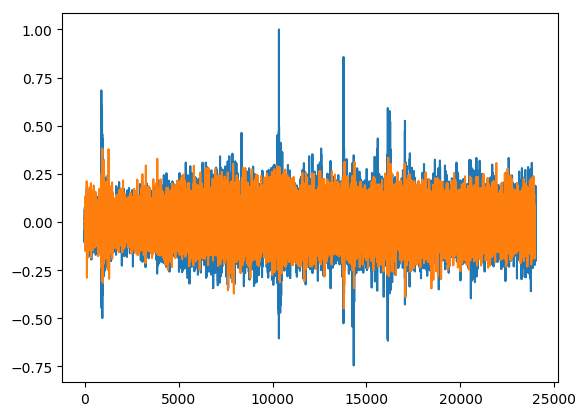

In [19]:
plt.plot(y_noise)
plt.plot(noise_pred)
audioplayers(y_noise, noise_pred, y_tot, fs=fs_desired)

## Plot results with total phase

In [20]:
speech_pred = warp_ifft(sqrt.(exp.(z_speech_pred)).*exp.(1im*angle.(f_tot)), pole_location, step_size)
noise_pred = warp_ifft(sqrt.(exp.(z_noise_pred)).*exp.(1im*angle.(f_tot)), pole_location, step_size)
;

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQAXLxC+z7Zpvpv5Nb7BxRS+yVvfvUVPfL38sEc9gVMKPp4fZT6sOp8+RpLDPsjZwD5W47o+J/2cPmR09T0v+uG8ABMfvdIXpb07sH++OCiXvvv6Nb44zZu9eM6Yva0/Er1fmx09L+SrPe4cPj3Td6g79Y9svcGes72gmOG9KaAYvpjcUr7g8k++VXYXvuUq2b3Ba7S98BKWvE0V6z0WIGg+qiaSPtcnsj4xVMc+Y+TFPuDxqD69wBs+2NTxu1vSK71/F5i9vD17vvfDo77n4mO+8qS2vXTgrb10upW9vXA4PH9ivD1+8JY9nkMiPULRnrt0sj+9+GfJveM3A77Zhzq+DQNXvrM9OL6sCAi+sZXHvbpjMbzNJAw+UVOEPtSsoD7E7b8+lADZPjDuyz6qLmI+9XYmPSq+FjzI8Bi90mNgvt28t75p/Iu+A/EWvlMvCr6i3BS+HQoavQEv0D0Iq/89vKxwPfizijwG9Qs9jrqmPCbCrr3Z1zq+jNJEvjVxJL4keiC+3EEZvjBXnr2MpI49GgVMPhV4iz4g558+QLHGPmZX0j61LJs+IPC5Pav9lTn/17Q7GYnlvXvDpb5c6K6+oVxTvlTMHr71mze+1FzzveH14zuZzZg9n3yTPbNvHD2AEQ08FFl1PPSTUjyR6Kq94BgpvteY+r0ZPju9XzhLveXiVbvRpDA+MiaoPh8xsz4ljbg+wQigPhDOIj4g8aU9z/JTPUZa+r372qC+scqNvkacQL4qYV2++HlsvhJk0L1r9h49hYK2PZHD6z0FNvk9WjKdPVZphz1ds349YJgfvW9DQb4m1Ua+HMIFvp7XM75TKmy+RjEHvjgZTzxV2ng92D26PcCMOT4EqYI+i0mDPsGPVD6ugzA+nTT+Pd5ZkT3xbRC83llsvRsUeL2MM7K9Zi0lvnssI75Xrci9qmi8vUkO6b25a3+9WxlBPIrrMbp3VjG9LP9DvX5R6bw4Y8C8yXmxvHVINLt5PVw9ZmgYPgJFbz52tZA+wOSpPkjMvD4cb10+Vm88PAl83js3LbM8YPhIvo/NvL5g8nK+dWXcvZbBRL5zn12+/pvOvFIVBT4EjQA+pJjcPXo8Kz7HFUc+/HAiPkS9jD0YLKG8DyWqvVi5yL26PQi+6EhIvjMYSL690Oe9d5x2vfPRhb3/iQe93rIZPc3ImD1w7EI9tIwWPRM6Iz12ePo8nF+evDZ0Wr19ITy9syPvvG29Er15zyi9GHsOvY9/fLz0kdU7UhQJPK29SbuupwW79bNwPKqtezsR28C8Q+kXvUARabyojWC8mO+ovOtARztuQAE9O+oRPY3LIT1TEmI9vn2EPcHQgz3EujY99mz+PN5srjyxd388neOGvOCDPL1jlki9KPNLvaiFkr0oW6C9Ln1uvTsOVb1AKly951kvve3xuLxGoaq8Qf5avI9sMTqm8lU8kjemPCPtPz3CPog9JVyJPUujoj18Htg9md/QPdIjqj2p2nM9GmcyPcUijzz7qcK8CXCJvXfc273twPu9SAf9vdNDBr63pBO+BRbqvTnfoL1asH29sqw4vYkKU7yfsCY8TInsPATsOD2tXGA9K3CdPfjN+j19jx0+HJc2Pk8AST4o1Ds+PEj6PcNEoz1OXjE9YVF6vXRoFr6T7ya+3KYqvtU1Zb7x9m2+/j0qvj428r0Zzum9xu6fvX7Q07tXrfA89JYiPYvTgj1k0Mo9iFTtPf3jAj4mTCc+cPBTPtYIdj6udmU+htXiPdV63Dwge1M9vX+dPMapEr735k++J+/CvQP7yr1nqU++0uQkvl9bpLzLzSW82hRBvXOvBz2OiOY9xPysPeHRRz3ahps9njuJPdkRpbsLRiy9cQUIvVe1cr1lJMq934HHveZXrr21qKC9TDiGvUnZL71YbZq84zRIvNWEdrwBssm7wMkpPM4rejzys/m76LGTuz0cLTykokE675GBvJZF3zqYr4E7isl6vKC5mLzmlDK877QhvCFiBLzrGwe6r07jOw+O5TuOvjs8hukfPHiPyjzZqSc9jOQCPWK/kTygYcs8prkOPdttqjw/CpE8t4bXPGwJkTxap6Y6fBP7OREFTbvFfRa8XxkQvOODHryLh/a7pHUmvL8viLv2IGy6uT3bujm90juoq907o3DyOwS4qjx/f6E8uRUgPLAyxzzr6u08fnY0PIqvADzeMdU8HSPQPOZwLjwI0xA8sAVSOzILqTokr5Q8kIm7O6IDg7znR+I6RTyOPL3EVrrK1sK7JZYDPDQ/szrRZ7Y7AIsmPBIvLDtIeyE7jBFaPDsFgDwAARs7hH8RPMzaTDyuOTw8zlTBPF2iyLo6ZJE8tPL0PNly1DtaB6s8SWicPMMzlbt9/ms8v/nEPKj4t7sMHI68kXQfOylYF7wQM0S8jqePO/gdALyFJiO79ZswPACm2Lxa+Da82j4PPTaVJDyygB69V96ivIolHj2vutY7sk05va6Cgjyi37M8f8dDvao/ITxQohA9G/Y2vWzkG7087vA8ds8gvHZAQr26KMe8BatsOg8e1rzddmC8Z9CCvMRz77zPfvo7IMpiPB0xRb2nppq8vr/xPLrtm7y4cQO9cV1iO98/R7qi6Ka8G8mYvEQiyDua4ku8Ix3yvMQpU7xLgY27j9Z+vH5R9rxO21i8xhomvG8TZ7xzjhG8FGmnuzRCarpED0K7Piphu4HWE7vWSow7K2tVusQh+LvaO5m62L7Luia8LLosKQC89vnuuxNNsbuJ1mW7HxDcOpENmDrwfVe4H8NhO505vjtvWYq7umlcu/lLbLuzBRW8uSUyvJNWI7yYOge853JsvCCbcbzEExi8dieCu6qi/rqmyGa7amHZO4RmPzyjY+E7JtqRO9AZDTyP+NM7cx4kO2+gczs/Bqk6dB+yOZ95gToomHe6duJ8ul2fBLtO4IM5qREzO8exSLsmhMq7zkXQu2lzDLxGUwa80nASvEz5mLt5esG5IXlaOyU8qDvIF5S5t/+XO8gjFTylxNs7+IHMufnwGDtobfk7AQMcOzJSO7uFx3Y75hbiO3Wgfjvm6Ii6sF+SOzpfzDtW9v87eOkPPADrQjzBxjo819owPDZQOTwbKQY8BjQJPNf9CjzdWSo7tTmeOwf7yzsilA08p89APAge/jvKXPQ78RcLPC218jvtO9Q7+N7dO7FfPTxVjyM8TU6aO0H28zv+bxY8JLL2O1zUZjzSvH48ZMY1PJ4TETzei0A8wx/BO2GtgjuNAL47QZFhu90NubtkewK8cOGLu2ansbu81me7TgNhO5bEcDuRUjg61wsJO0ZtOjs/mCK6FAPBu2KV77vH1Cu8SXgivEy3TbwE/oe88OKTvF7TfbyEho+8oKyXvHYSUrxByne8n4aGvP3NirwysYK8B5mdvBpjp7wcYKO8sFe5vKGqrLxUgaq8/TygvG3eurwW+HG8vLFQvK58j7yxnl+8qD9bvMu4OLxnvYO8LF6jvEvuo7zclJ+8OtB+vK2Khbzr74G8D7R7vE80c7wNDI68VpiVvNH8dLyHfji8r5p/vEljY7yaeSO8jH4XvB9mILz6QYC7WDAFvBtELrykpfO7xXF9u0yikLvsYHK7A3zfu3nYPrtvjP43F5YGu1T9vTr3LmA6Xy8vOyoTaTtfRoo6rANJO+pBQzuGWLK7Gh0WusPwgzqXDfQ6mtKgOqpKgDtpneo70NaMO4hIyTslITU8UscMPGiMUDw313I8v+MoPDIvQzzHsAw8lpQ7PF8yGDxrCyM8mORJPLBP+Dufq/c7xpsjPJOQZDw86x48J6lAPCwxfjxhQDg8WXcQPC16VzwATHM8W3GKPEi8gjx/tHk8PXhuPLExmzxGg448aMlIPOf8QzyiX

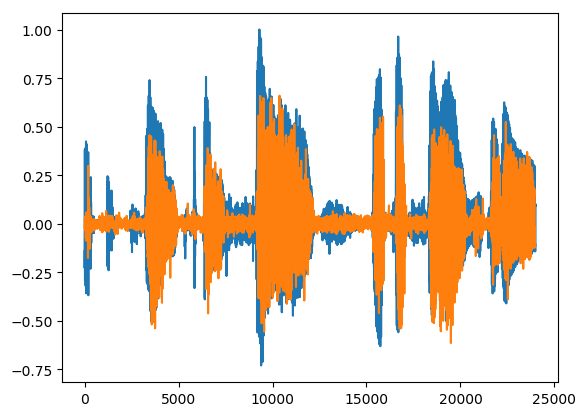

In [21]:
plt.plot(y_speech)
plt.plot(speech_pred)
audioplayers(y_speech, speech_pred, y_tot, fs=fs_desired)

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQDK80G94H7ZvTg4mb01RXC9sSnKPDokebzHbAO8i29PPZ65hz2IW5m66eC1PKIiz70AB4m9pjJTvWuxwLttCTk9v1WhPTkpdT1FlK08dg8pvTRoMz0dWJw9d3qiPQgQWT1tSL48SvssvQHwPLwAwSO84dBPuyay5jwyE/Q7rJOdPQEsIztWYby8uJ24vX9mZ72fhvG9Z3Xevc+Jwr2dvMO90uiiPG59G7yuFP88CJ26PRInHD3WdGg9fNxXPVUxtTx6f8c9qWwLPXSDajxAtXO7+VitvKNcFztdQ+E7C0mCuprfMLxr7Xo9lyoxOyQ7RzxiKZq78yxLu09hlTtiTCA9C4c6PZbEXr3E8A+8g02rO6jigzxxdpY7ha5bPdDeB7zYFQK8b6Ukvbu4pby2fL68DXdjPTT5ujwDk8A96LIwvUOqOjsU4G+9Rtzrvf3eYr18xBC7VxuWvUFFaL1ksAC8/ISOPVRICj08jV08KUULvWnktL2de5m9UhS/vcS5zrw4emi9VARuu0dbqr1ylzK80tPfuwECOz3NP6A9eIOUvBukNz1gezI9lGHfPJHD0byEzvS6NQ4nveeqbj2Yq9M8aTpYPH9kNj60yM28CVaPPfcZo7xK48i8dVtEPIzCgT0kBKE9dZxePCMBTT2XD1o9vFqFvNyO6ruzH4+8GJqdvaSMvrx80Y69sSjSvHqV9zxO7hc9GbMSPP3E6bx7PUO9kpoPvEcIHT18Gk09nqnKvA9koLwg/8a9sT/yvAoMJL2abC6984M5vZPGKr11VoC9ChvIvYL6jL1q7QK9timPPSEOmT2Tb6o97QT0PWIIjT1RxAw8CF7Su0S0LbyPGzU9XwsBuyxM1z0iSZm9iUJMvZkdbLsaUAY9XmujPV3RjzwWGwW9Qpg6PQpg/DwcHGU9OjMFPU2ABLtrz7u8WvudvBB3ULoLHd+6Qoh6vaAqB7zsuYA72V5+PcH6tbwyJXS8zS+CvVgStLxgkZ09il+APZXMuT3i5qs9Fqwsu2DtYT0HY2S84P92vWMRa70BI3e7zRQ/vb4F6bzY5zq+AiQIvgMc+Lz//gu94XZVvQusTLzTs4c8RKBPvFj5Tb1xfSk9pMc+PUh9j7zBDYy9tyOMvaV4tr0PXGC9VP8xPb65kT2AbJM8yxXfvPkd2zyV0FW7+a3IOutz8z3EhG49CJqhPdAhCj7yjBw+d/GYPcRRDDu1JA28SSFyO0s+mz3HLa89WIs8vfIN0byFory9LeXavb/AQjxD/bG9j2hZvBRV0jwzqze9BJyWPeAu/j3bGL89pcgVPvZEzz0DMZm8mk+dPTgV+TxXas28llh+u4uQLL57vQC+8M2cvVpVvr15pWe9fBfEvTwc6bxVC4M82ANAPC3Phr3AzKC9RedKPKaTtL2sKsc9Oa0dPttBoDx2mzy9LLK/vSgX47w6iHo8Y6KxvDewir2VdZo8hgJ8PN6U4ruRyXu7XQyevEVCmzybpeg80Wcau8FVQ70M4Og9b1p9PD4f/zzfqYG9pKvvvEoQoTwVhPo7LmIYPPpAez0OO687yZcVPOfq5jxC/xe9rkgmPT9Jvz1rMI887bGbvJrCzzwI8Jw9pQmNPWz9m730Uh69RmEvvfXRfb0bIGe89yYDvZfZaz2SQW08CKUOvUy2ND3tNtY9pWe7PR5WaL1OLbq9dQ/3vAmbtr1uYY294iLevAq1KT12C5e9D3n0vCbYtb1HCZu9KaeUvN75Nj3jQaU8gisEvW+D3Dk7RxC92vOZvesZEz2ZfOo9r6QRPgwV1z263KA90vuqPfoeeT1NSxU9j7BIPWVeWT2kMsk8xMsgPblcTjzcmYY8DVutN7rhAr2NV4m8o6qEvAT5QrsLluk6Aq4QPcpbkLnR4Ui9QdwSvXPIsr28vCy+71lHvgGkkL2w1hs8ttnHPBrYqDuK/0S81IOIvVOzRDyX3V49DKQGPfHDqD2B0Zm76xc7vbq0yTzTn2s8TfMTvePVB732VRS8UTlnvDlq9jsMTPK86FelvYR2vL3RN1O9KtSAvaNZr7zHrCw9Te/YPFm2qT1ELG49OCPGvC4Nkb0RuRO6kAw1vY+80Du8V+E9S28HPtRGIT2A6og9Nl1CPBHMWz2KQbk8ryidPQEb+T2DUYA9lpWxPdrh4zyx3nQ9bIHcvEVuKLvGmyg6cHW6vAR6H70WDtS9ZZWTveohgb0Qots8zBf4PQ4Zlz3T44E9sugoPSGeEz06Ffa8QrzMvJdI6TuQqMy9YbULvg/XIr4HJtK9zYGJvdpzgLwzJ5S7WhWmvU6o3bi/qC89V7pGPEAUwDzgWSY9VJQ4PVjF+Tyjmr87P1+DPQGNWz2JRPQ8wvMbPV6zGD2/EUQ9SWDevCzlM72wIr69NSSUvUC0e72v4wK+pADxvcBsr72rEcm7gjv/PN/k5TwqvR09jSSePDGJhz1TyqA9+rS9PZ9LPT18PpA9SxuvPMhr0r0wWli9BYvEPFOxdDz+Wui7I1gLPfMIE7y0+y08XoQ6vdr+cL3fBrE8skqKPYH7gzwmJAQ9Ai4mPVcyY71lA7A734IKvP8rlDyMZUY9UdxJvZsLxDzC5H29OnyVvZYZorvPvoM9Wr6tPbpfOrxMBzw9D8h1PUqrIb2gG8U7sxtZPTUIXbycf6a8RReOPDqig7wimY6991iSO67pn7wshQa9uJ0Eut30Tr2XLS28lqspPSLJnL19yu68NyFuPTf0JT5C+L0970GcvVJJp73e6hi7fkNBPb3yCb3MhGo8F1k7vSrpg72xl8a8K5yRvf4A6b3iqG29LUD3vDSIxj3qtfQ9yTZnPQW7uz3w+Pw9xG53Pc0aDz1SfmY8xe5zvQh2zr12qhq+L8oRvpTHSr2bGj09Qj4APtV9vj1G8tY7/VDOOwBBgLtL1Qq9cjdOPRbowzzjBNW79RTsPMjWLL0Vei69Ci2PvY/THT3WQHw96CT3PBBfZL0r3IK9zPmZPJKHoTxxJ0U9tqmPPYOfcL3WBc296vGxvFBhrbwEQm+7RWfGPEKXPj38f0E9rnkDPlhcqj3lJ3s9hLoXPcxj5zt/Vk87kY1ovAD8jr12GM+8rnbSvXG6AL4Fpo+95twqvNrRXr2eMni9dRvNvTxULr57Eay91ll5vcsKOT1TdHA9mQRRu1jHVD2+raQ9XIqiPP9XpD1E4pw9bI0gPUrXNT3AEYk9jrpaPJhGlDy1L+49EujOPE0MvTxFSiI8PhdHvN/L5z2AYw88A/+PvN4rFz3LjfA8LjmFum7jDT1R2KI7eufXurakP72CJYm9XR9tvDYkWb0rkR69uYtgvIw4cL3eI4y9m6Cuur3SLjygmsY9wlQoPQq9VLyQXMg7wh5+vPbSmr3z7ay86R5APQDH6jxh96M9yIUYuwapVr3bmwi9kYLcvYAEv725KIi9CIJ6vRTOrjx2nca8QvAFvX1KOT0xPKI8yfShvV0Sq7x24dg8tVUMPUnjez3CqOM9hQymPWC18Txl4bg9LkJ6PLCYvrwwJUe8K39rvdB4G72c+lK9BxpmPD8VrzzJt4Y7C88EPTzgLTuPSSw94ywAverwkbwnr5G608oFvXEL3Lz6Pr+9Ye8BvdZ7dD20jfC4BaswvYJlaL0hqpi99v1kvT5YKD2AdiC85ltuPFh+ETwf1CY9wpt8PAraoj3P0Ig96GSJPOQmszzF95i9ITr/O/EFSbx7lYS9ivvYvBgMA72xdcc9yw4GPkz9eD2wFAA+pSe6PQaHrz3jkqg8OalUPU1gijy4np09nt15PcT4ar1HlTu8168zvlXuiTxBB6Y9VPhKveyJ9rwpIxG+IdTTvUDLMb2Ince8g30ovoOpBb3JNJy9fGOrPawNXz1y2

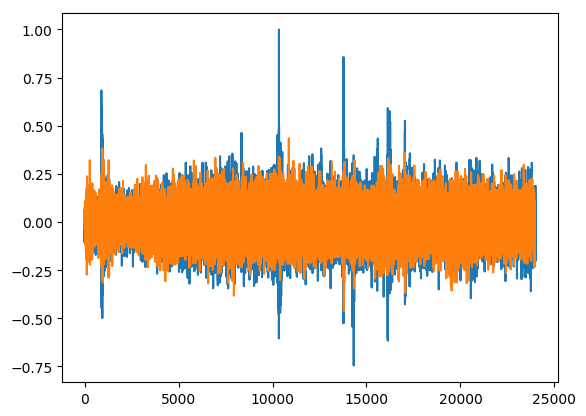

In [22]:
plt.plot(y_noise)
plt.plot(noise_pred)
audioplayers(y_noise, noise_pred, y_tot, fs=fs_desired)